In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# import data
train_df = pd.read_csv('train.csv', dtype=np.float32)
test_df = pd.read_csv('test.csv', dtype=np.float32)

# separate features/labels
targets_np = train_df.label.values
features_np = train_df.loc[:, train_df.columns != 'label'].values/255

# split train/dev sets
features_train, features_dev, targets_train, targets_dev = train_test_split(
    features_np, targets_np, test_size=0.025, random_state=42)

# create tensors
features_train_tensor = torch.from_numpy(features_train)
targets_train_tensor = torch.from_numpy(targets_train).type(torch.LongTensor)
features_dev_tensor = torch.from_numpy(features_dev)
targets_dev_tensor = torch.from_numpy(targets_dev).type(torch.LongTensor)

# batch size, iterations, epochs
batch_size = 100
n_iters = 10000
num_epochs = int(n_iters / (len(features_train_tensor) / batch_size))

# create tensor datasets
train_dataset = TensorDataset(features_train_tensor, targets_train_tensor)
dev_dataset = TensorDataset(features_dev_tensor, targets_dev_tensor)

# data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

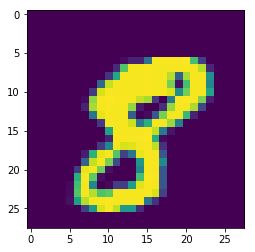

In [3]:
# visualize an item in the dataset
plt.imshow(features_np[10].reshape(28,28))

In [4]:
# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # input dimensions (28x28)
        self.input_dim = input_dim
        
        # number of units in hidden layer
        self.hidden_dim = hidden_dim
        
        # number of layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # output layer (fully-connected)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # initialize hidden state with 0s
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # one-step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [5]:
# Create RNN
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
learning_rate = 0.05

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
# training
seq_dim = 28 # (28, input_dim) = (28,28)
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        
        # reshape input to (28,28)
        train_images = Variable(images.view(-1, seq_dim, input_dim))
        train_labels = Variable(labels)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward propagation
        output = model(train_images)
        
        # calculate loss
        loss = error(output, train_labels)
        
        # backpropgation
        loss.backward()
        
        # update parameters (gradient descent)
        optimizer.step()
        
        count += 1
        
        # evaluate model accuracy every 250 iterations
        if count % 250 == 0:
            correct, total = 0, 0
            for dev_images, dev_labels in dev_dataloader:
                train_images = Variable(images.view(-1, seq_dim, input_dim))
                
                # forward propagation
                output = model(train_images)
                
                # get predictions
                predicted = torch.max(output.data, 1)[1]
                
                # track accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum()
                
            accuracy = 100 * (correct / float(total))
            
            accuracy_list.append(accuracy)
            loss_list.append(loss.data)
            iteration_list.append(count)
            
            if count % 500 == 0:
                print(f'Iteration: {count}, Loss: {loss.data.item()}, Accuracy: {accuracy}')
                


Iteration: 500, Loss: 1.9485975503921509, Accuracy: 33.0
Iteration: 1000, Loss: 0.9404590725898743, Accuracy: 58.0
Iteration: 1500, Loss: 0.541139543056488, Accuracy: 87.0
Iteration: 2000, Loss: 0.6397339701652527, Accuracy: 93.0
Iteration: 2500, Loss: 0.24719342589378357, Accuracy: 95.0
Iteration: 3000, Loss: 0.4211540222167969, Accuracy: 98.0
Iteration: 3500, Loss: 0.15771137177944183, Accuracy: 97.0
Iteration: 4000, Loss: 0.1352563500404358, Accuracy: 100.0
Iteration: 4500, Loss: 0.20350202918052673, Accuracy: 96.0
Iteration: 5000, Loss: 0.05750627815723419, Accuracy: 100.0
Iteration: 5500, Loss: 0.07498563826084137, Accuracy: 98.0
Iteration: 6000, Loss: 0.14936000108718872, Accuracy: 99.0
Iteration: 6500, Loss: 0.1463417261838913, Accuracy: 98.0
Iteration: 7000, Loss: 0.09371471405029297, Accuracy: 98.0
Iteration: 7500, Loss: 0.14179153740406036, Accuracy: 97.0
Iteration: 8000, Loss: 0.1650865226984024, Accuracy: 99.0
Iteration: 8500, Loss: 0.05050913989543915, Accuracy: 100.0
Iter

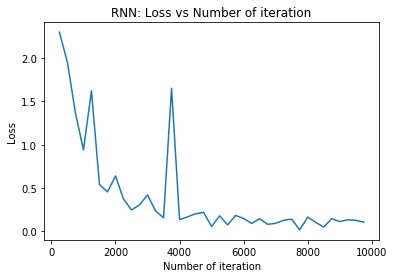

Text(0.5,1,'RNN: Accuracy vs Number of iteration')

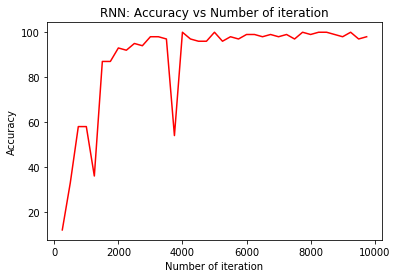

In [8]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")